In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import liana as li

In [2]:
import muon as mu
import plotnine as p9
import mofax as mofa

/home/dbdimitrov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
INVERSE_FUN = lambda x: -np.log10(x)
groupby = 'cell_type_original' # NOTE: the same cell types but readable; TODO abbvreviate this garbage
sample_key = 'sample'
condition_key = 'patient_group'

In [4]:
resource = pd.read_csv(os.path.join('results', 'lr_pairs.csv'))
cell_pairs = pd.read_csv(os.path.join('results', 'cell_pairs.csv'))

In [5]:
resource = resource[resource['top1std']]

Run LIANA + MOFA

In [6]:
adata = sc.read_h5ad(os.path.join('results', 'kuppe_processed.h5ad'), backed='r')

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [7]:
mdata = li.multi.lrs_to_views(adata,
                              score_key='magnitude_rank',
                              inverse_fun=INVERSE_FUN,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.3, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 15, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 10, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 24/24 [00:00<00:00, 146.79it/s]


In [8]:
mdata

MuData object with n_obs × n_vars = 28 × 5771
  obs:	'patient_group'
  24 modalities
    CM&CM:	28 x 279
    EN&CM:	28 x 252
    CM&FB:	28 x 243
    CM&PC:	28 x 210
    CM&EN:	28 x 217
    FB&EN:	28 x 244
    FB&CM:	28 x 308
    FB&PC:	28 x 238
    FB&MY:	28 x 242
    PC&CM:	28 x 264
    FB&VM:	28 x 313
    FB&FB:	28 x 276
    EN&VM:	28 x 259
    MY&MY:	27 x 185
    EN&PC:	27 x 199
    VM&VM:	28 x 304
    EN&EN:	28 x 203
    PC&PC:	27 x 204
    VM&EN:	28 x 230
    EN&FB:	27 x 223
    VM&FB:	28 x 267
    MY&FB:	27 x 184
    PC&FB:	28 x 233
    PC&EN:	28 x 194

In [9]:
outfile = os.path.join('results', 'models', 'mofatalk.h5ad')

In [10]:
model = mu.tl.mofa(mdata,
                   use_obs='union',
                   outfile=outfile,
                   seed=1337,
                   n_factors=10,
                   convergence_mode='slow',
                   scale_views=True,
                #    copy=True
                )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Loaded view='CM&CM' group='group1' with N=28 samples and D=279 features...
Loaded view='EN&CM' group='group1' with N=28 samples and D=252 features...
Loaded view='CM&FB' group='group1' with N=28 samples and D=243 features...
Loaded view='CM&PC' group='group1' with N=28 samples and D=210 features...
Loaded view='CM&EN' group='group1' with N=28 s

In [11]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=condition_key)
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,patient_group
0,CK158,-2.849745,-0.338345,-0.191991,0.006606,0.053538,-0.063088,-0.004009,0.059511,-0.227959,-0.029807,myogenic
1,CK159,-0.305626,-0.795326,-0.274958,-0.298118,0.062698,-0.072241,-0.030387,0.134209,-0.186136,-0.073079,myogenic
2,CK160,0.125592,0.325610,-0.359246,0.901155,0.071212,-0.063259,-0.072644,0.076844,-0.156197,-0.023928,myogenic
3,CK162,0.431643,-0.551106,-0.330753,-0.166344,0.084170,-0.065241,-0.039978,0.108197,-0.215714,1.505037,fibrotic
4,CK163,-1.390721,-0.719640,-0.471316,-0.140483,0.079070,-0.060611,-0.052569,0.088434,-0.134663,-0.053536,myogenic


In [12]:
model = mofa.mofa_model(outfile)
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 28
Features: 5771
Groups: group1 (28)
Views: CM&CM (279), CM&EN (217), CM&FB (243), CM&PC (210), EN&CM (252), EN&EN (203), EN&FB (223), EN&PC (199), EN&VM (259), FB&CM (308), FB&EN (244), FB&FB (276), FB&MY (242), FB&PC (238), FB&VM (313), MY&FB (184), MY&MY (185), PC&CM (264), PC&EN (194), PC&FB (233), PC&PC (204), VM&EN (230), VM&FB (267), VM&VM (304)
Factors: 10
Expectations: W, Z

Explore Results

In [13]:
factor_of_interest = "Factor1"

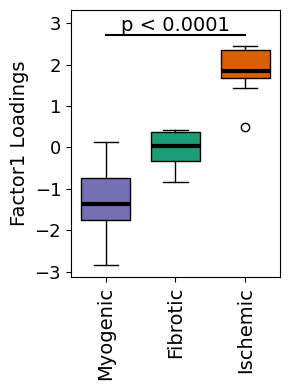

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway

# Assuming factor_scores is your DataFrame and condition_key is the column for conditions
factor_scores[condition_key] = factor_scores[condition_key].str.title().astype('category')
labels = ['Myogenic', 'Fibrotic', 'Ischemic']

# Set the color palette and style
colors = ['#7570b3', '#1b9e77', '#d95f02']

# Create a boxplot
plt.figure(figsize=(3, 4))
box_positions = np.arange(1, len(labels) + 1)

max_y = float('-inf')
min_y = float('inf')

for i, label in enumerate(labels):
    subset = factor_scores[factor_scores[condition_key] == label][factor_of_interest]
    plt.boxplot(subset, positions=[box_positions[i]], widths=0.7, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black', linewidth=3))
    max_y = max(max_y, max(subset))
    min_y = min(min_y, min(subset))

# Perform one-way ANOVA
groups = [factor_scores[factor_scores[condition_key] == group][factor_of_interest] for group in labels]
statistic, p_value = f_oneway(*groups)

pval = round(p_value, 3)

# Add comparison lines and p-value
y = max_y + 0.1 * max_y  # adjust 0.05 to change the height of the comparison lines
plt.plot([1, 3], [y, y], color='k')
plt.text(2, y, f'p < {pval+ 0.0001:.4f}', ha='center', va='bottom', size=14)

# extend y axis
plt.ylim(min_y*1.1, max_y + 0.35 * max_y)

# Set labels and title
plt.xlabel('')
plt.ylabel(f'{factor_of_interest} Loadings', fontsize=14)
plt.title('')
plt.xticks(box_positions, labels, fontsize=14, rotation=90) 
plt.yticks(fontsize=13)
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
variable_loadings =  li.ut.get_variable_loadings(mdata,
                                                 varm_key='LFs',
                                                 view_sep=':',
                                                 pair_sep="&",
                                                 variable_sep="^") # get loadings for factor 1
variable_loadings.head()

# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5



In [16]:
variable_loadings.to_csv(os.path.join('results', 'kuppe_mofa_loadings.csv'))

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


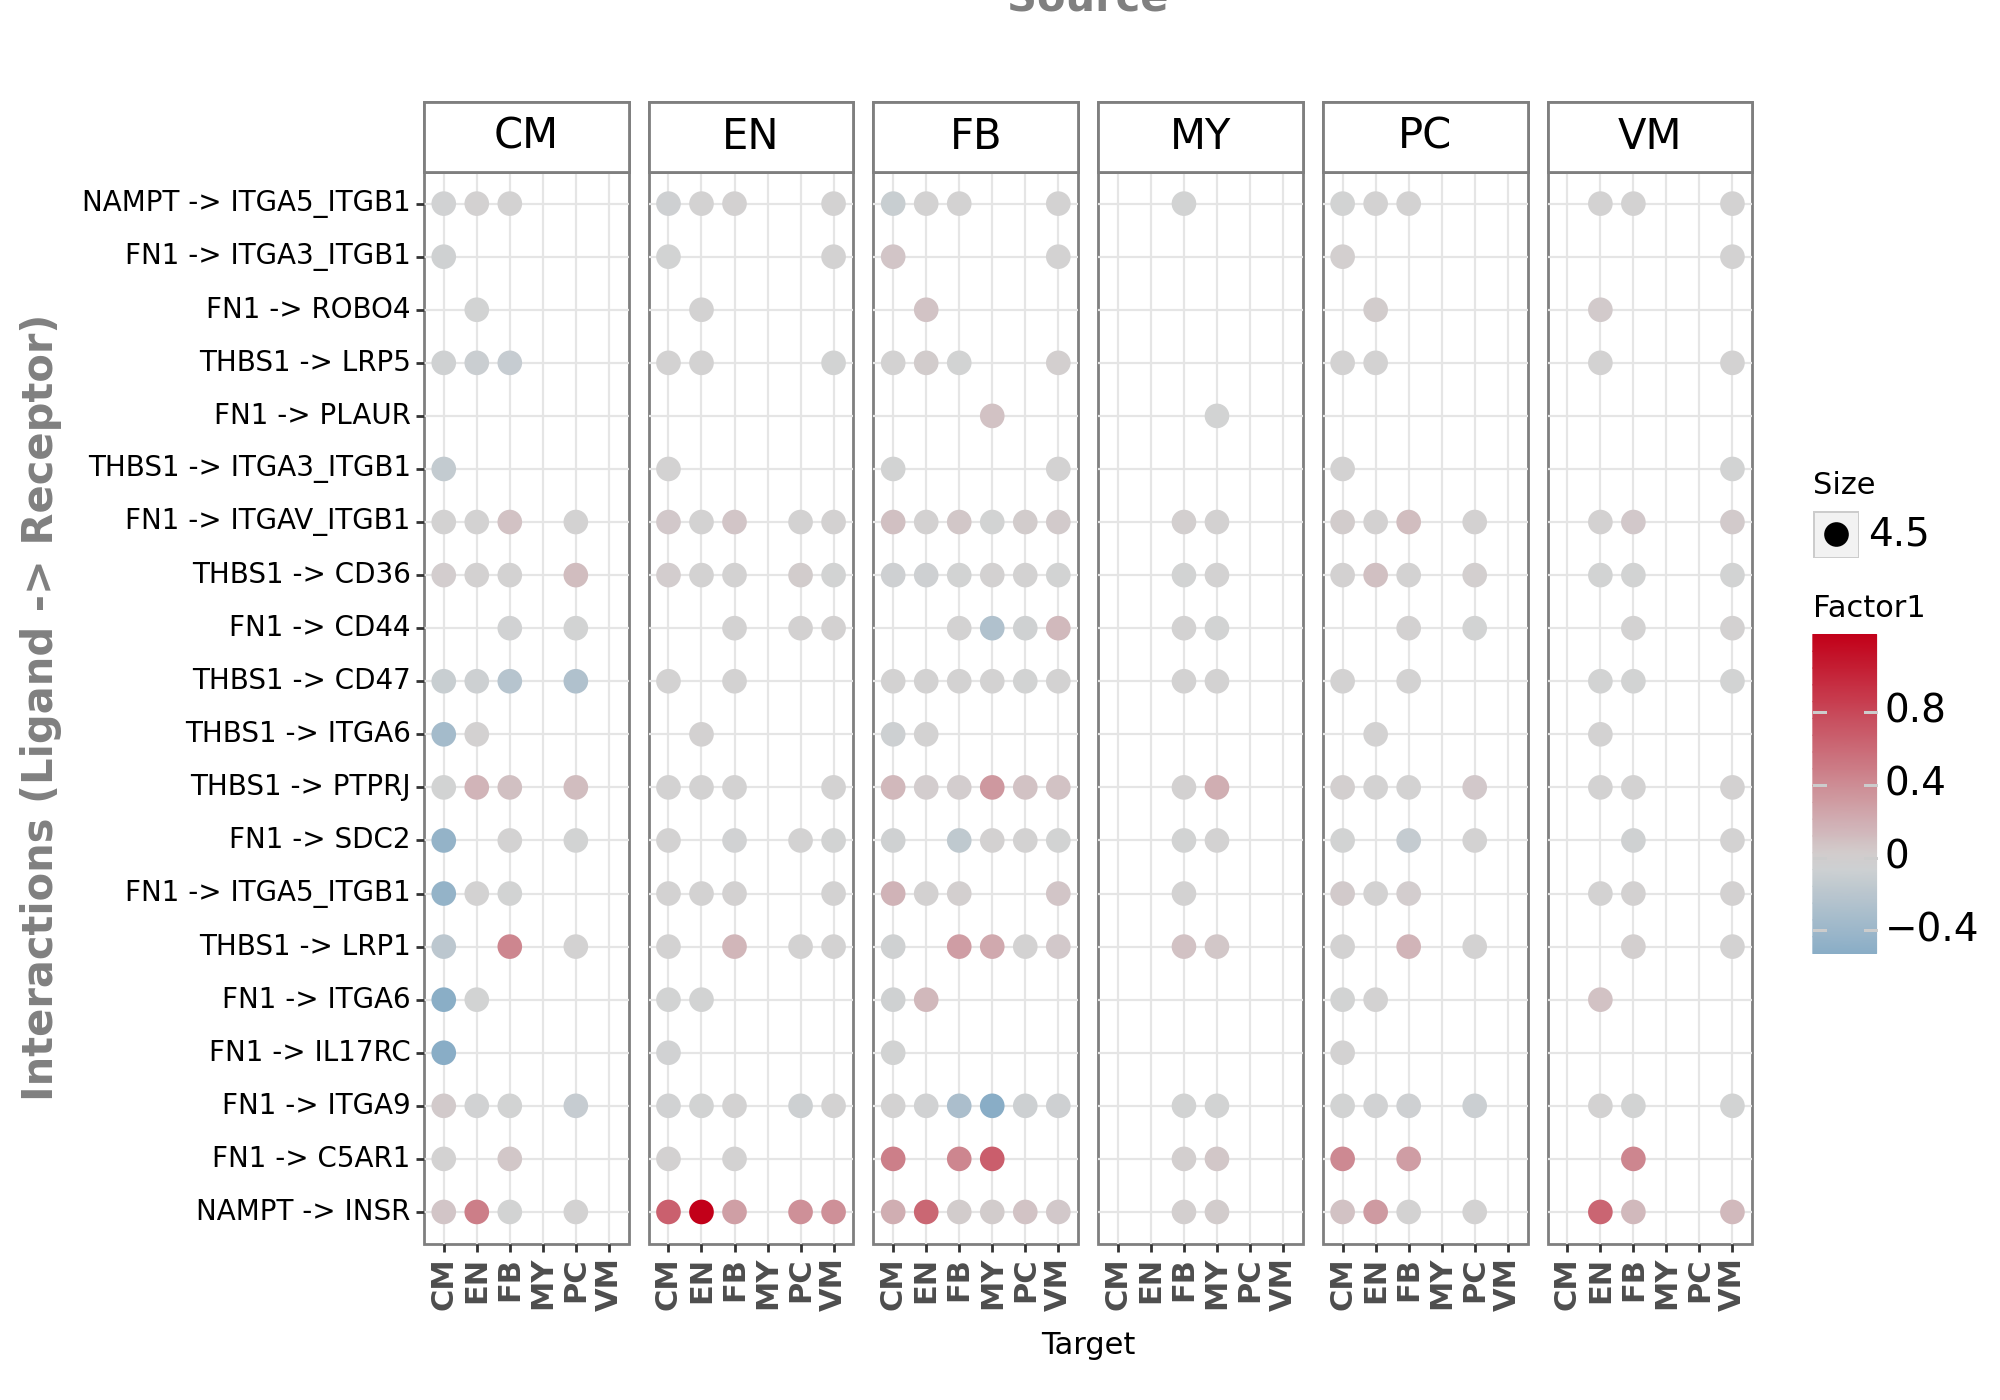

<Figure Size: (1000 x 700)>

In [17]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour=factor_of_interest,
                        orderby=factor_of_interest,
                        ligand_complex=["FN1", 'NAMPT', 'TNC', 'THBS1', 'SPP1'], 
                        top_n=20,
                        orderby_absolute=True,
                        orderby_ascending=False,
                        size_range=(0.1, 4),
                        figure_size=(10, 7)
                        )
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0)

In [18]:
# import omnipath as op
# inter = op.interactions.import_intercell_network()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


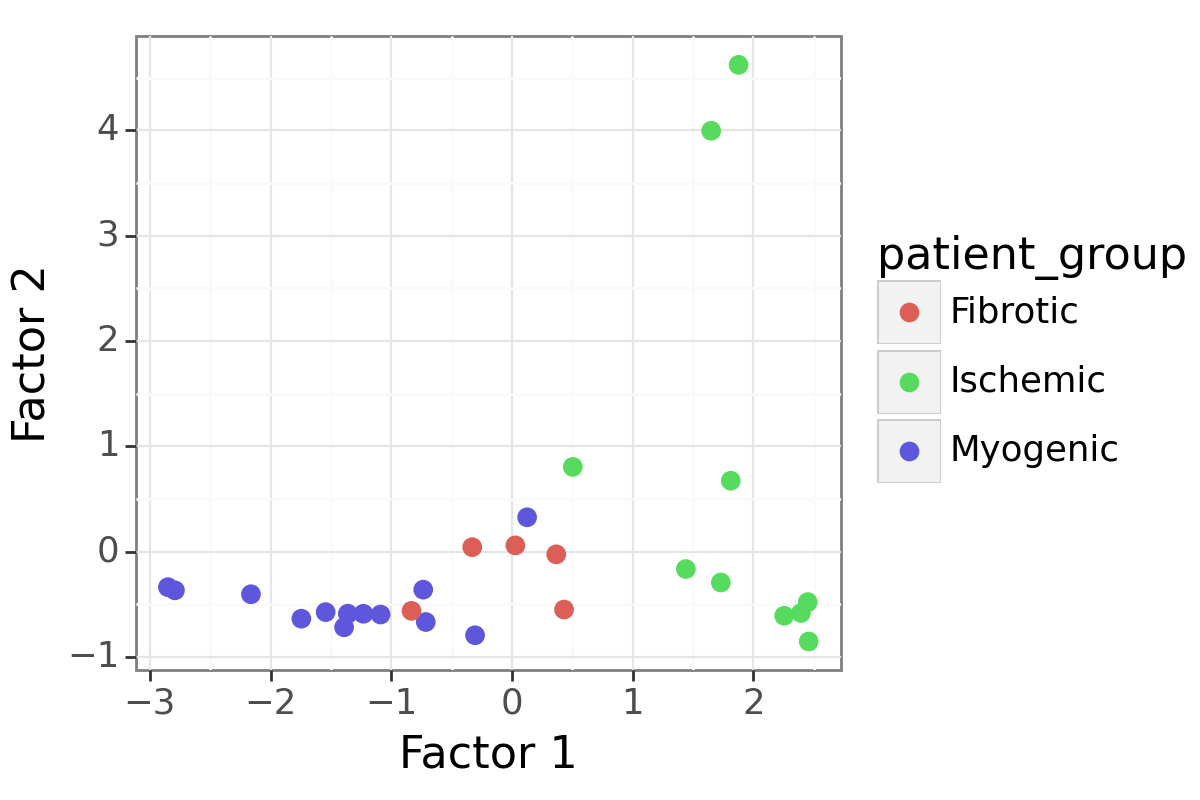

<Figure Size: (600 x 400)>

In [19]:
# dotplot of Factor1 (x) and Factor2 (y)
(
    p9.ggplot(factor_scores) +
    p9.aes(x='Factor1', y='Factor2', colour=condition_key) +
    p9.geom_point(size=3) +
    p9.theme_bw(base_size=16) +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(x='Factor 1', y='Factor 2')
)

Factor 1 R2 per view

In [20]:
# get variance explained by view and factor
rsq = model.get_r2()
factor_rsq = rsq[rsq['Factor']==factor_of_interest]
# separate view column
factor_rsq[['source', 'target']] = factor_rsq['View'].str.split('&', 1, expand=True)

In [21]:
# Remove adipocyte as it does not explain much
factor_rsq = factor_rsq[~((factor_rsq['source'] == 'Adipocyte') | (factor_rsq['target'] == 'Adipocyte'))]

In [22]:
factor_rsq.sort_values("R2", ascending=False).head(15)

,Factor,View,Group,R2,source,target
5,Factor1,FB&EN,group1,27.021419,FB,EN
16,Factor1,EN&EN,group1,26.806564,EN,EN
7,Factor1,FB&PC,group1,25.695723,FB,PC
8,Factor1,FB&MY,group1,25.343832,FB,MY
17,Factor1,PC&PC,group1,24.954484,PC,PC
14,Factor1,EN&PC,group1,23.957593,EN,PC
13,Factor1,MY&MY,group1,22.667155,MY,MY
23,Factor1,PC&EN,group1,21.707092,PC,EN
4,Factor1,CM&EN,group1,21.276338,CM,EN
19,Factor1,EN&FB,group1,21.107754,EN,FB


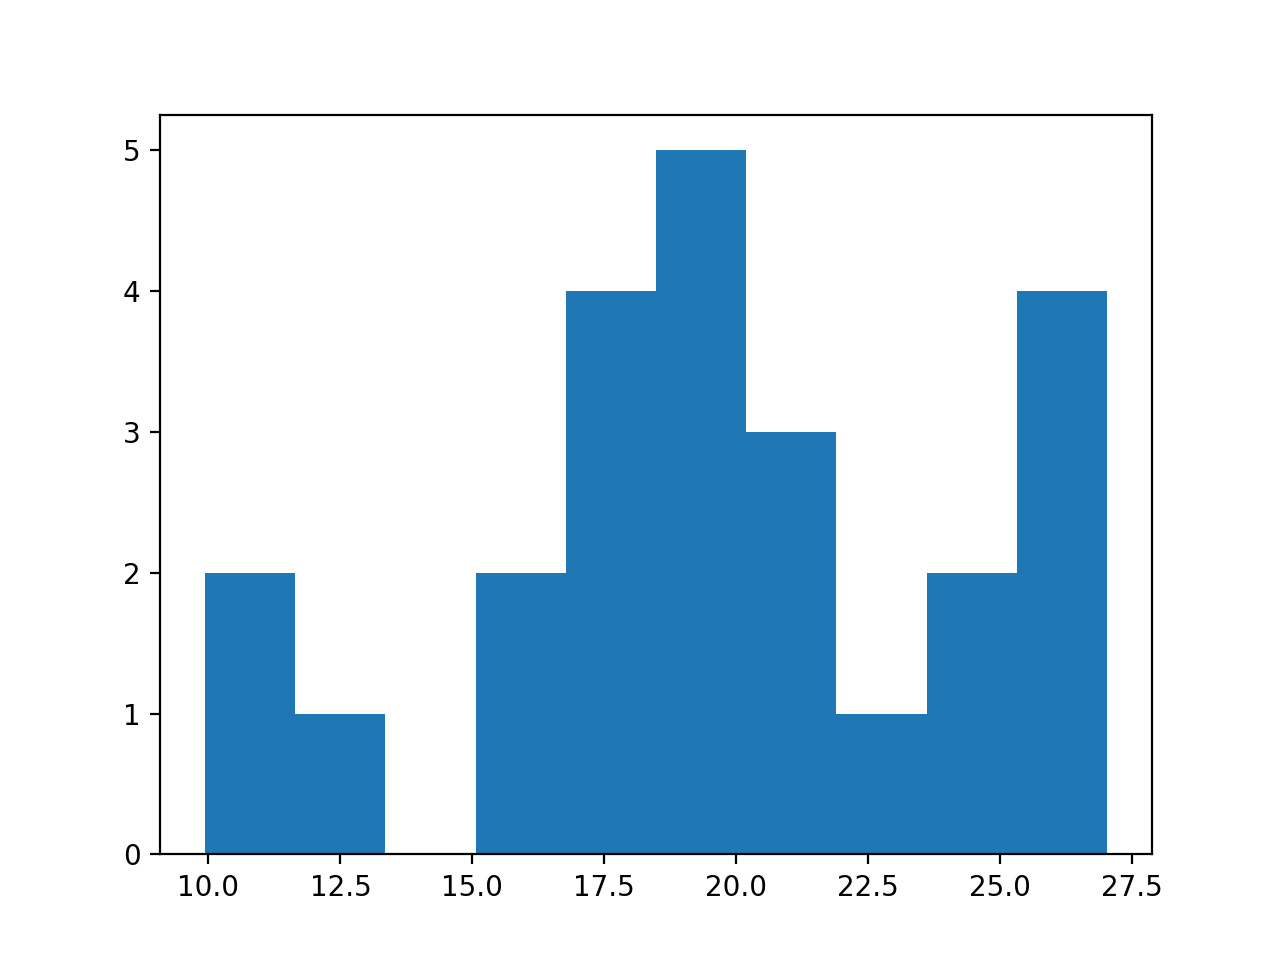

In [23]:
plt.hist(factor_rsq['R2']);

In [24]:
factor_rsq['source'] = factor_rsq['source'].astype('category')
factor_rsq['target'] = factor_rsq['target'].astype('category')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


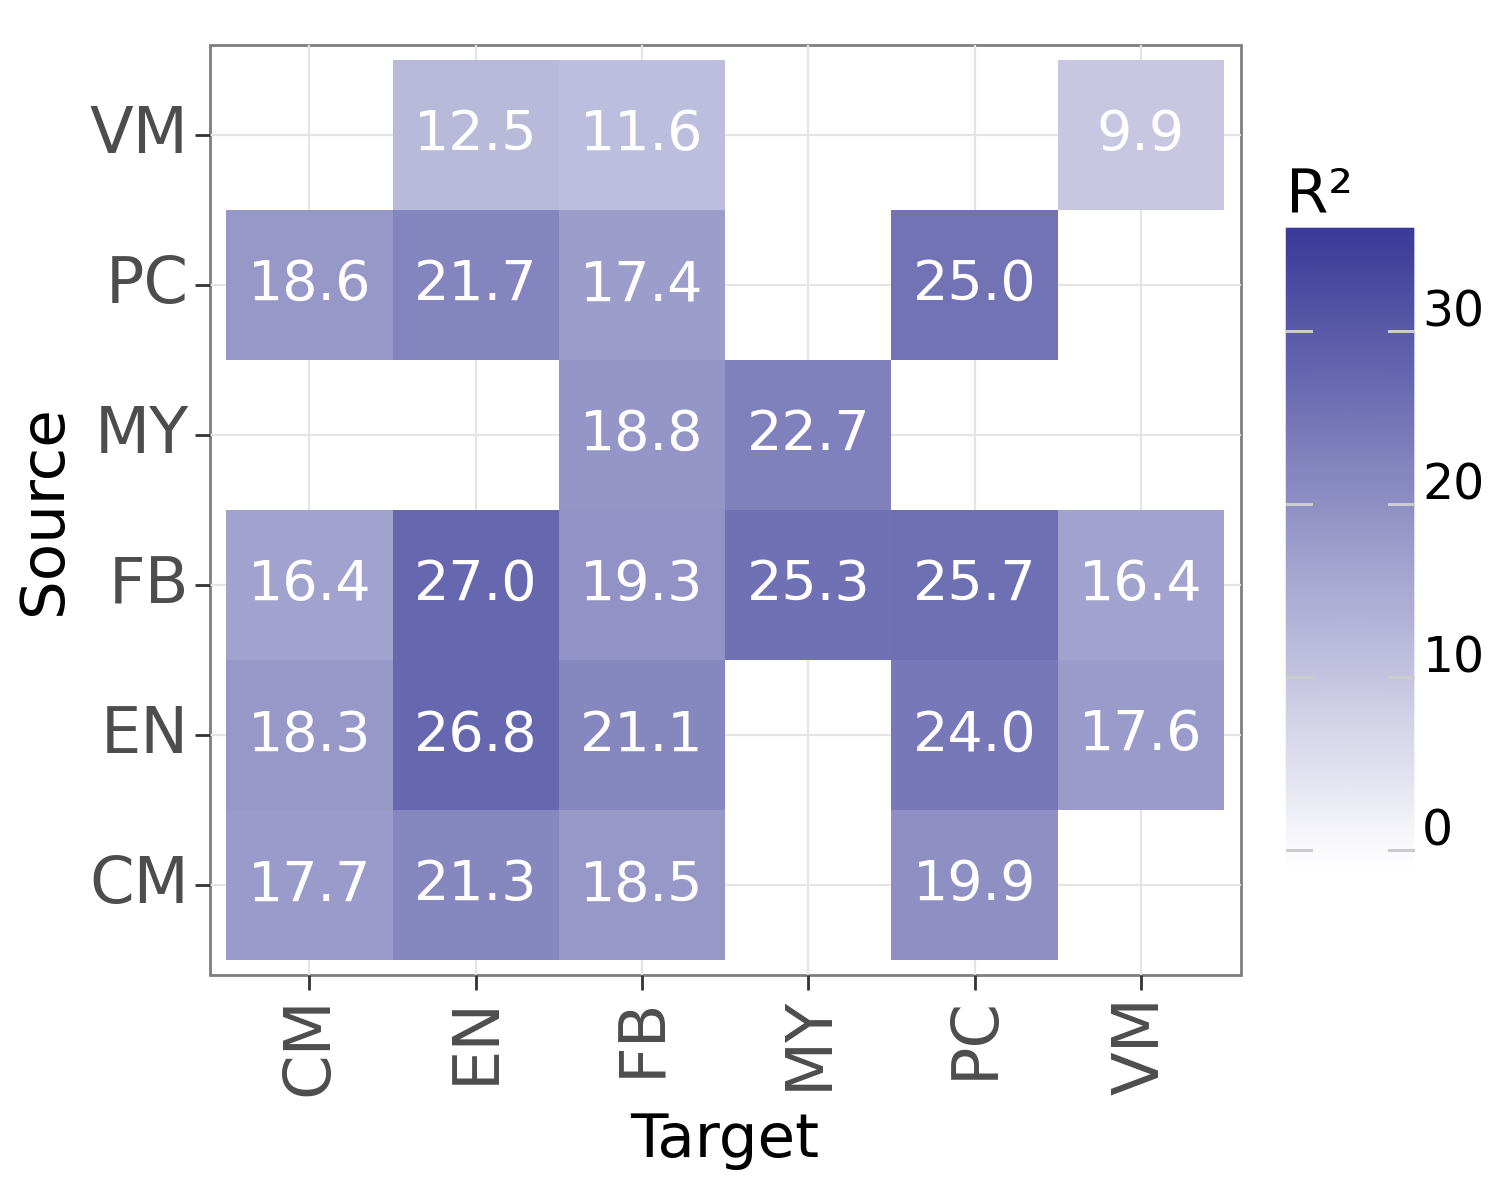

<Figure Size: (750 x 600)>

In [25]:
(p9.ggplot(factor_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
 # geom text
    p9.geom_text(p9.aes(label='round(R2, 1)'), size=20, color='white') +
    p9.scale_fill_gradient2(limits=(0, 35)) +
 p9.theme_bw(base_size=22) +
 p9.labs(x='Target', y='Source', fill='R²') +
 p9.theme(axis_text_x=p9.element_text(rotation=90, size=23), figure_size=(7.5, 6), axis_text_y=p9.element_text(size=23))
)

In [26]:
variable_loadings.sort_values(by="Factor1", ascending=False, key=abs).head()

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size
4066,CALM1,RYR2,EN,EN,-2.071868,-0.029571,-0.047938,0.011558,-0.258595,-0.061032,-0.211008,-0.041814,-0.020342,-0.407725,4.5
3117,CALM1,RYR2,EN,VM,-2.058672,-0.020240,-0.011979,-0.007725,-0.405528,-0.033302,-0.084482,-0.005400,-0.072266,-0.075662,4.5
2266,CALM1,RYR2,PC,CM,-1.942642,0.002136,0.049408,0.095214,-0.431646,-0.189513,0.038893,-0.014904,0.110159,-0.262175,4.5
3112,CALM1,CACNA1C,EN,VM,-1.917633,-0.020347,0.027658,0.174060,-0.072975,0.009161,0.086772,-0.001382,-0.100644,0.830156,4.5
4421,THBS4,CD36,PC,PC,-1.911810,-0.048499,-0.903489,-0.470178,0.146805,-0.015762,-0.035240,0.009419,-0.031117,0.048994,4.5


In [27]:
ct_int = variable_loadings[(variable_loadings['source']=='FB') & (variable_loadings['target']=='MY')]

In [28]:
# rank by absolute values of Factor 1
ct_int['rank'] = ct_int['Factor1'].rank(ascending=False)

In [29]:
ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(5)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank
2127,LAMA2,CD44,FB,MY,-1.349208,-0.008654,0.638826,0.205298,0.100462,0.153335,-0.087476,-0.390130,-0.000569,0.012605,4.5,242.0
2077,DCN,TLR2,FB,MY,-1.282188,-0.023612,0.310330,-0.076269,0.301657,-0.015174,0.071794,0.038162,-0.003658,-0.049882,4.5,241.0
2128,LAMA2,ITGA9_ITGB1,FB,MY,-1.177685,-0.012911,0.243996,0.055796,-0.511742,-0.051646,0.188668,0.004179,0.002865,-0.000784,4.5,240.0
2031,CALM1,RYR2,FB,MY,-1.088627,-0.004351,-0.089655,0.020946,-0.498536,-0.037571,-0.428732,0.037094,-0.003984,-0.069599,4.5,239.0
2135,LAMC1,CD44,FB,MY,-0.992374,-0.000813,-0.005583,0.222284,0.155666,-0.003945,-1.797522,-0.197216,0.002812,0.012023,4.5,238.0


In [30]:

ct_int['name'] = ct_int['ligand_complex'] + ' -> ' + ct_int['receptor_complex']
# # keep name for only the top 5 by absolute values of Factor 1
# ct_names = ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(1)['name'].tolist()
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_names else '')
# keep top 1 according to rank
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int.sort_values(by='rank', ascending=True).head(1)['name'].tolist() else '')
## keep name where ligand_complex=="LAMA2" and receptor_complex=="ITGA6_ITGB1" (top 3)
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['ligand_complex']=="LAMA2"]['name'].tolist() else '')
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['receptor_complex']=="ITGA6_ITGB1"]['name'].tolist() else '')

In [31]:
ct_int.sort_values("Factor1").tail(10)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
2149,NAMPT,INSR,FB,MY,0.042838,0.029994,0.881417,-0.006845,-0.945412,0.237487,-0.197426,-0.061221,0.004888,-0.045283,4.5,10.0,
2054,COL1A2,CD36,FB,MY,0.066651,1.692274,-0.047857,-0.173510,-0.312911,0.046054,0.012509,0.029593,-0.002815,-0.014781,4.5,9.0,
2095,FN1,PLAUR,FB,MY,0.097958,1.901001,-0.033460,0.026543,0.279611,2.290902,-0.247430,-0.074071,-0.003291,-0.001293,4.5,8.0,
2119,IGF1,INSR,FB,MY,0.112102,-0.014320,0.631449,-0.011369,-0.703610,0.017861,2.758259,-0.041156,-0.001549,-0.032209,4.5,7.0,
2173,SERPINE1,PLAUR,FB,MY,0.114391,0.743668,0.485104,-0.016437,0.159422,6.915177,-0.962170,0.022978,-0.002367,-0.016795,4.5,6.0,
2201,THBS1,LRP1,FB,MY,0.236135,0.077088,-0.006598,0.970960,-1.067763,1.511484,-0.032730,-1.919265,-0.002196,-0.053553,4.5,5.0,
2202,THBS1,PTPRJ,FB,MY,0.324764,0.000111,0.002858,1.422479,-0.302493,0.086045,-0.131698,-1.470287,-0.000150,-0.036751,4.5,4.0,
2051,COL1A1,CD36,FB,MY,0.467906,1.387743,-0.229907,-0.045355,-0.663840,-0.035527,0.010257,-0.025450,0.001415,-0.039514,4.5,3.0,
2172,SERPINE1,LRP1,FB,MY,0.612280,0.128971,0.368469,-0.017960,-0.121036,4.687422,-0.510210,0.063274,-0.000971,-0.036068,4.5,2.0,
2090,FN1,C5AR1,FB,MY,0.646962,1.133179,0.019471,-0.008848,0.230999,1.464702,-0.204116,-0.011055,0.001358,-0.052067,4.5,1.0,FN1 -> C5AR1


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


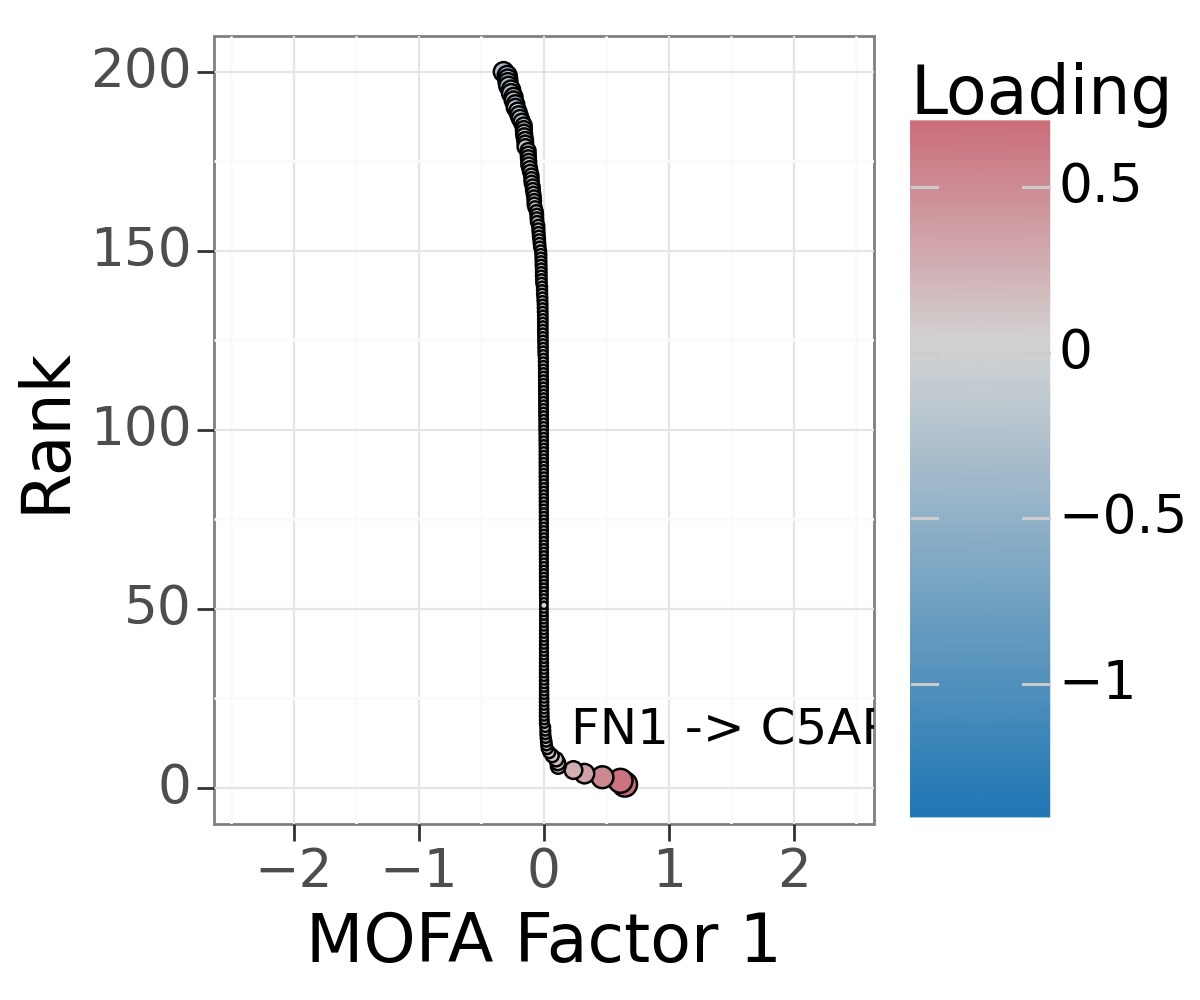

<Figure Size: (600 x 500)>

In [32]:
ct_int['size'] = ct_int['Factor1'].abs()
(
    p9.ggplot(ct_int) +
    p9.aes(x='Factor1', y='rank', fill='Factor1', size='size') +
    p9.geom_point() +
    p9.geom_text(p9.aes(label='name'), size=18, nudge_x=1, nudge_y=15) +
    p9.theme_bw(base_size=24) +
    p9.theme(figure_size=(6, 5)) +
    p9.scale_x_continuous(limits=(-2.4, 2.4)) +
    # scale rank to 0-200
    p9.scale_y_continuous(limits=(0, 200)) +
    p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0) +
    p9.labs(x='MOFA Factor 1', y='Rank', fill='Loading') +
    # hide size
    p9.guides(size=False)
)

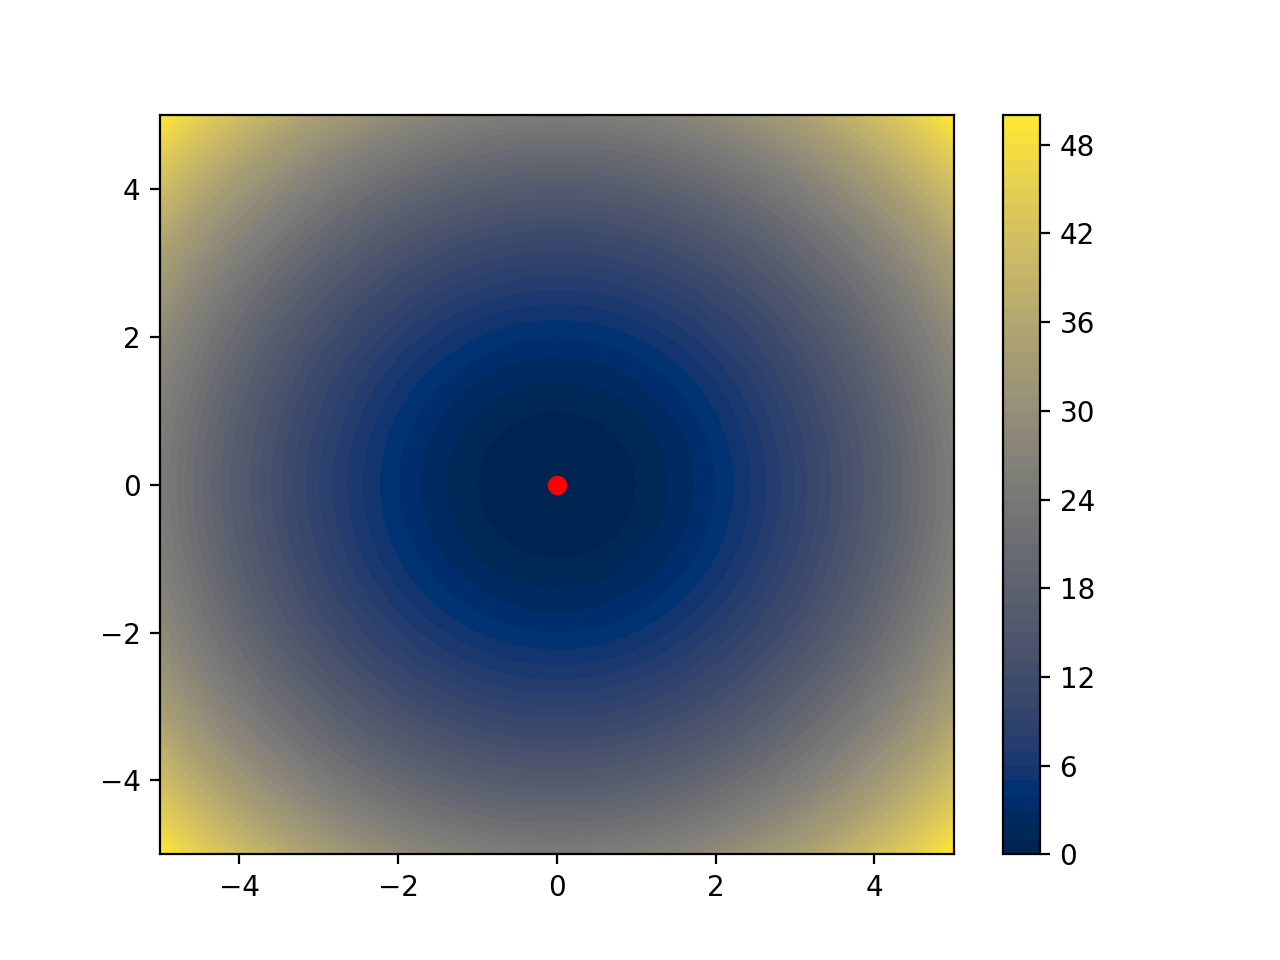

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def f(x, y):
    return x**2 + y**2

# Create a meshgrid of x and y values
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)

# Contour plot
cp = ax.contourf(X, Y, Z, 50, cmap=cm.cividis)
plt.colorbar(cp) # Add a colorbar to the plot

# Mark the global minimum
ax.plot(0, 0, 'ro') # 'ro' for red circle
